# Movie Sentiment Analysis with XGBoost

This notebook performs sentiment analysis on a dataset related to movies using various features like `movie_info`, `critics_consensus`, and `tomatometer_rating`. The analysis includes data preprocessing, sentiment labeling, and model training with XGBoost.


# Importing Libraries

This section of the notebook includes the necessary libraries for performing data preprocessing, sentiment analysis, and model training. Libraries like pandas, numpy, sklearn, and XGBoost will be imported to facilitate efficient data handling and analysis.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.sparse as sp


# Loading the Dataset

Let's load the dataset to understand its structure.


In [3]:
data = pd.read_excel(r'C:\Users\User\Desktop\python\Rotten_Tomatoes_Movies3.xlsx')

In [4]:
print("First row of the dataset:")
data.head(1)

First row of the dataset:


,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,The Breaking Point,In this taut adaptation of Hemingway's To Have...,commented,NR,Drama,Michael Curtiz,Ranald MacDougall,"John Garfield, Patricia Neal, Phyllis Thaxter,...",1950,2017,97,Fresh,100,7,84


## Data Cleaning with Power Query and Excel

The data cleaning process was performed using Power Query and Excel. This involved handling missing values, removing duplicates, and transforming the data to ensure it was ready for analysis and model training.


# Data Preprocessing

## 1. Filtering Movies Based on Runtime

We filter the dataset to consider movies with runtime between 30 and 200 minutes.


In [5]:
data = data[(data['runtime_in_minutes'] >= 30) & (data['runtime_in_minutes'] <= 200)]


## 2. Removing Movies with Audience Rating Over 100

We exclude movies with audience ratings above 100, if applicable.


In [6]:
if 'audience_rating' in data.columns:
    data = data[data['audience_rating'] <= 100]


## 3. Processing the `tomatometer_status` Column

We convert the `tomatometer_status` to numerical values for model compatibility.


In [7]:
if 'tomatometer_status' in data.columns:
    data['tomatometer_status'] = data['tomatometer_status'].astype('category')
    data['tomatometer_status'] = data['tomatometer_status'].replace(['Rotten', 'Certified Fresh', 'Fresh'], [0, 2, 1])


C:\Users\User\AppData\Local\Temp\ipykernel_12628\242567730.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['tomatometer_status'] = data['tomatometer_status'].replace(['Rotten', 'Certified Fresh', 'Fresh'], [0, 2, 1])
C:\Users\User\AppData\Local\Temp\ipykernel_12628\242567730.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data['tomatometer_status'] = data['tomatometer_status'].replace(['Rotten', 'Certified Fresh', 'Fresh'], [0, 2, 1])


## 4. Extracting the Year from `in_theaters_date` and `on_streaming_date`

We extract the year from `in_theaters_date` and drop `on_streaming_date`.


In [8]:
if 'in_theaters_date' in data.columns:
    data['in_theaters_year'] = pd.to_datetime(data['in_theaters_date'], errors='coerce').dt.year

if 'on_streaming_date' in data.columns:
    data['on_streaming_year'] = pd.to_datetime(data['on_streaming_date'], errors='coerce').dt.year
    data.drop(columns=['on_streaming_date'], inplace=True)


# Sentiment Analysis Function

We define a function to classify the sentiment of movie-related text based on polarity using `TextBlob`.


In [9]:
def get_sentiment(text):
    blob = TextBlob(str(text))
    if blob.sentiment.polarity > 0:
        return 1  # Positive
    elif blob.sentiment.polarity < 0:
        return -1  # Negative
    else:
        return 0  # Neutral

## 5. Applying Sentiment Analysis

We apply sentiment analysis to `movie_info` and `critics_consensus` columns to create a new `film_sentiment` column.


In [10]:
def apply_sentiment(row):
    if row['critics_consensus'] == 'no comments':
        # Only use 'movie_info' for sentiment analysis when 'critics_consensus' is 'no comments'
        return get_sentiment(row['movie_info'])
    else:
        # Combine 'movie_info' and 'critics_consensus' for sentiment analysis
        combined_text = str(row['movie_info']) + " " + str(row['critics_consensus'])
        return get_sentiment(combined_text)



In [11]:
data['film_sentiment'] = data.apply(apply_sentiment, axis=1)


## 6. Mapping Sentiment Values to Movie-Related Labels

We map the sentiment values to movie-related labels.


In [12]:
sentiment_mapping = {1: 'Positive', -1: 'Negative', 0: 'Mixed'}
data['sentiment_label'] = data['film_sentiment'].map(sentiment_mapping)

## 7. Visualizing the Sentiment Distribution

We visualize the sentiment distribution in a pie chart.


In [13]:
sentiment_counts = data['sentiment_label'].value_counts()

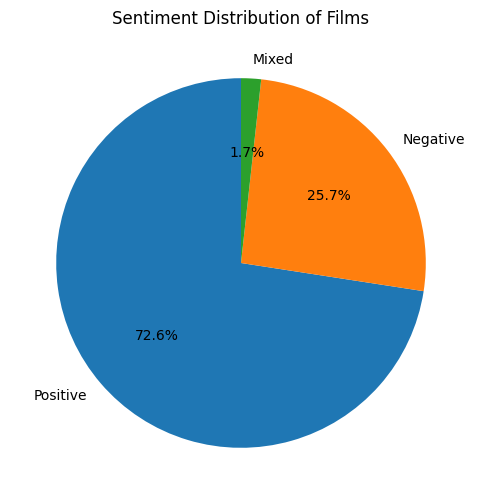

In [14]:
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution of Films')
plt.show()


## 8. Vectorizing Text Columns and Combining with Numerical Features

We vectorize the `movie_info` and `critics_consensus` text columns using `CountVectorizer` and combine them with numerical features.


In [16]:
vectorizer = CountVectorizer()
movie_info_vectorized = vectorizer.fit_transform(data['movie_info'].astype(str))
critics_consensus_vectorized = vectorizer.fit_transform(data['critics_consensus'].astype(str))
X = sp.hstack([movie_info_vectorized, critics_consensus_vectorized, 
               data[['tomatometer_rating', 'tomatometer_count', 'in_theaters_year']].values])



## 9. Target Variable

The target variable is `film_sentiment` (or `sentiment_label` for a classification model).


In [17]:
y = data['film_sentiment']

## 10. Splitting the Data into Train and Test Sets

We split the data into training and testing sets for model training.


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
Model Training with XGBoost
We use XGBoost to build a regression model and evaluate it.


In [19]:
# XGBoost Model with early stopping in the constructor
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42, 
                             early_stopping_rounds=100)


In [20]:
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-rmse:0.87160
[1]	validation_0-rmse:0.86749
[2]	validation_0-rmse:0.86356
[3]	validation_0-rmse:0.86003
[4]	validation_0-rmse:0.85643
[5]	validation_0-rmse:0.85358
[6]	validation_0-rmse:0.85107
[7]	validation_0-rmse:0.84816
[8]	validation_0-rmse:0.84589
[9]	validation_0-rmse:0.84343
[10]	validation_0-rmse:0.84120
[11]	validation_0-rmse:0.83906
[12]	validation_0-rmse:0.83738
[13]	validation_0-rmse:0.83530
[14]	validation_0-rmse:0.83359
[15]	validation_0-rmse:0.83164
[16]	validation_0-rmse:0.83025
[17]	validation_0-rmse:0.82866
[18]	validation_0-rmse:0.82680
[19]	validation_0-rmse:0.82498
[20]	validation_0-rmse:0.82348
[21]	validation_0-rmse:0.82195
[22]	validation_0-rmse:0.82050
[23]	validation_0-rmse:0.81959
[24]	validation_0-rmse:0.81807
[25]	validation_0-rmse:0.81665
[26]	validation_0-rmse:0.81537
[27]	validation_0-rmse:0.81400
[28]	validation_0-rmse:0.81258
[29]	validation_0-rmse:0.81117
[30]	validation_0-rmse:0.80988
[31]	validation_0-rmse:0.80847
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## 11. Model Performance with XGBoost

- **Mean Squared Error (MSE):** 0.5524552171889705
- **Mean Absolute Error (MAE):** 0.605026719586645
- **Root Mean Squared Error (RMSE):** 0.7432733125768546


In [21]:
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print("\nModel Performance with XGBoost:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Model Performance with XGBoost:
Mean Squared Error (MSE): 0.5524552171889705
Mean Absolute Error (MAE): 0.605026719586645
Root Mean Squared Error (RMSE): 0.7432733125768546
